In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pysm3
import pysm3.units as u
from noise import S4_LAT
from misc import camb_clfile
from fgbuster import CMB,harmonic_ilc
import pymaster as nmt

In [2]:
cl_len = camb_clfile("/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat")

In [3]:
noise = S4_LAT(el=50,ellmax=15000,deconv=False)
Nl_T= noise.noise_curves_T()
Nl_P= noise.noise_curves_P()
bands = noise.bands

/global/u2/l/lonappan/workspace/s4bird/cmbs4_noise/noise.py:155: RuntimeWarning: divide by zero encountered in power
  ellf = (ell/self.Tatmos_ell[:,None])**(self.Tatmos_alpha[:,None])
/global/u2/l/lonappan/workspace/s4bird/cmbs4_noise/noise.py:156: RuntimeWarning: invalid value encountered in multiply
  T_noise = self.Tatmos_cov[:,:,None] * (ellf[:,None,:] * ellf[None,:,:])**.5
/global/u2/l/lonappan/workspace/s4bird/cmbs4_noise/noise.py:159: RuntimeWarning: divide by zero encountered in power
  P_low_noise = (2*W[:,None]) * (ell / self.Patmos_ell[:,None])**self.Patmos_alpha[:,None]
/global/u2/l/lonappan/workspace/s4bird/cmbs4_noise/noise.py:161: RuntimeWarning: invalid value encountered in multiply
  (P_low_noise[:,None,:] * P_low_noise[None,:,:])**.5)


In [4]:
def inv_var(Nl):
    return 1/sum(1/a for a in Nl)
def ilc_weights(m_list):
    y = np.vstack(m_list)
    C = np.cov(y)
    C_inv = np.linalg.inv(C)
    w = np.sum(C_inv, axis=1) / np.sum(C_inv)
    return w
def map_coadd(m_list, w):
    m = sum(a * b for a, b in zip(w, m_list))
    return m
def nl_coadd(nl,w):
    m = sum(a*b for a, b in zip(w**2,nl))
    return m

In [5]:
bands = noise.bands
beams = noise.beams

In [6]:
NSIDE=1024
sky = pysm3.Sky(nside=NSIDE, preset_strings=["c1"])
Tmaps_list = []
for idx in range(len(bands)):
        maps = sky.get_emission(bands[idx]* u.GHz)
        maps= maps.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(bands[idx]*u.GHz))
        Nl_T[idx][0] = 0
        noiseI = hp.synfast(Nl_T[idx],nside=NSIDE)
        Tmaps_list.append(maps.value[0]+noiseI)
Tw = ilc_weights(Tmaps_list)

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/camb_lenspotentialCls.dat
  warnings.warn(f"Access data from {full_path}")
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/delens_ells.txt
  warnings.warn(f"Access data from {full_path}")


In [7]:
components = [CMB()]
class make_experiment:
    def __init__(self,bands,beams):
        self.frequency = bands
        self.fwhm = beams
inst = make_experiment(bands,None)

In [28]:
binning = nmt.NmtBin(nside=NSIDE, nlb=5, is_Dell=False)
bins = np.int_(binning.get_effective_ells())
result = harmonic_ilc(components, inst, np.array(Tmaps_list),lbins=bins)
w = result.W

In [29]:
nl_hilc = np.zeros(len(w))
for i in range (len(w)):
    nl_hilc[i] = np.dot(Nl_T[:, i], w[i][0]**2)

array([[0.14285773, 0.14285785, 0.14285771, 0.14285762, 0.14285768,
        0.14285794, 0.14285347]])

In [21]:
# nl_hilc = np.zeros(len(bins))
# for i in range (len(bins)):
#     nl_hilc[i] = np.dot (Nl_T[:, bins[i]], w[bins[i]][0]**2)

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(2, 24258.582511589746)

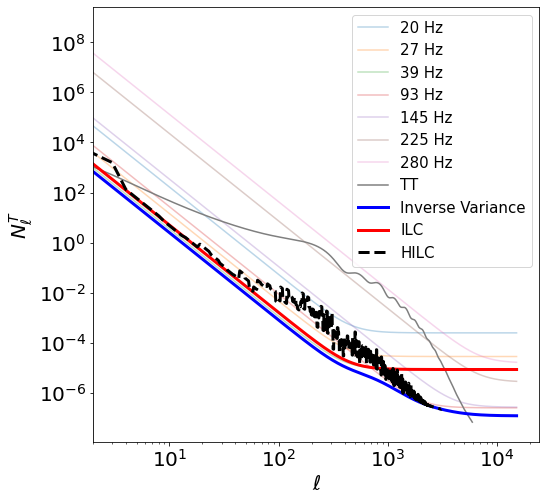

In [30]:
plt.figure(figsize=(8,8))
for idx in range(len(bands)):
        plt.loglog(noise.ell,Nl_T[idx],label=f"{int(bands[idx])} Hz",alpha=.3)
plt.loglog(np.arange(len(cl_len['tt'])),cl_len['tt'],label='TT')
plt.loglog(noise.ell,inv_var(Nl_T),c='b',lw=3,label="Inverse Variance")
plt.loglog(noise.ell,nl_coadd(Nl_T,Tw),c='r',lw=3,label="ILC")
plt.loglog(np.arange(len(w)),nl_hilc,c='k',lw=3,ls='--',label="HILC")
plt.legend(fontsize=15)
plt.xlabel("$\ell$",fontsize=20)
plt.ylabel("$N_\ell^T$",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(2,None)